# Using Cross-Validation for linear regression

Roll angle trend in CHEOPS data is usually complecated and needed sinusoidal functions with multiple degress of roll angle to model the trend. In this tutorial, we will try to model the roll angle trend using the linear regression: the model will be sinusoidal functions with multiple degrees of the roll angle. We will use the technique of cross-validation to find the optimal degree of roll angle to model the trend.

In this work, we used the roll-angle trend in KELT-11 dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils as utl
import os

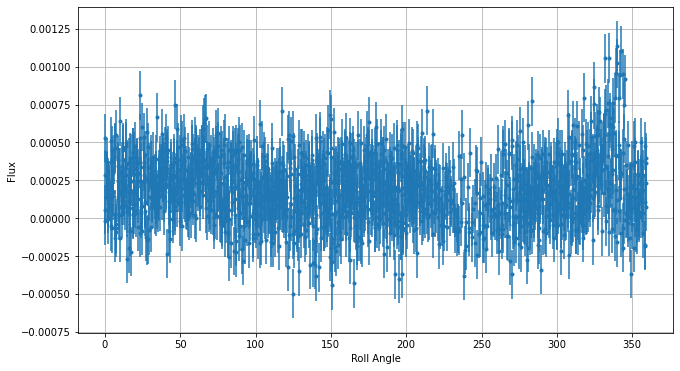

In [2]:
roll, fl, fle = np.loadtxt(os.getcwd() + '/Data/roll-angle-trend-kelt11.dat', usecols=(0,1,2), unpack=True)

# This is how the trend looks like
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(roll, fl, yerr=fle, fmt='.')
plt.xlabel('Roll Angle')
plt.ylabel('Flux')
plt.grid()

Let's see how well the first degree sinusoidal function will do...

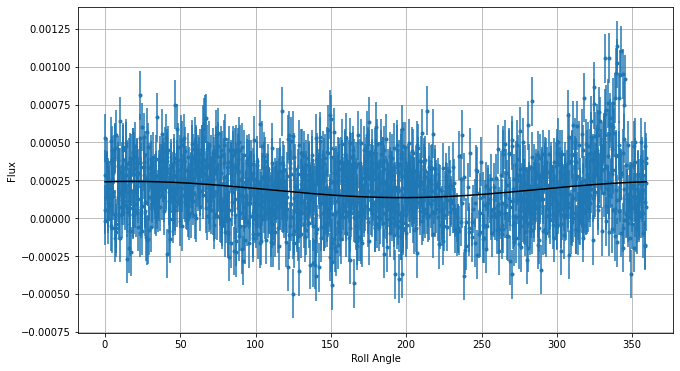

In [3]:
design = utl.des_mat(1, roll)
bets, covs = utl.gls(design, fl, fle)
model_y = design @ bets

plt.figure(figsize=(16/1.5,9/1.5))
plt.errorbar(roll, fl, yerr=fle, fmt='.', zorder=5)
plt.plot(roll, model_y, 'k', zorder=10)
plt.xlabel('Roll Angle')
plt.ylabel('Flux')
plt.grid()

That's not good. What about 10th order?

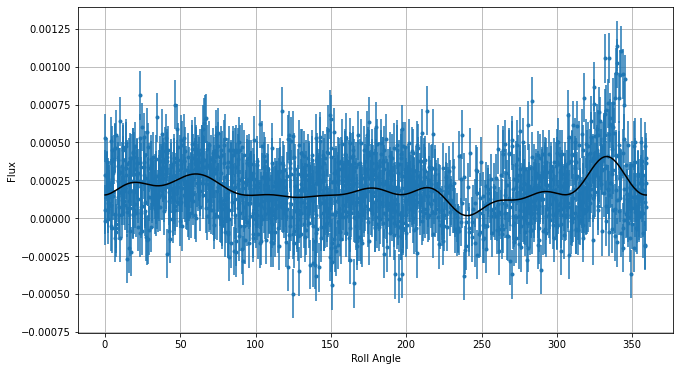

In [4]:
design = utl.des_mat(10, roll)
bets, covs = utl.gls(design, fl, fle)
model_y = design @ bets

plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(roll, fl, yerr=fle, fmt='.', zorder=5)
plt.plot(roll, model_y, 'k', zorder=10)
plt.xlabel('Roll Angle')
plt.ylabel('Flux')
plt.grid()

We will now use cross-validation to find the optimal model. The idea is that we will divide the dataset into training and test set: we then fit our model to the training set and test set -- we will then compute the $\chi^2$ for both of the sets for a range of models. Comparing the $\chi^2$ over a range of models can give us an idea on optimal value of degree of sinusoidal functions needed to model the roll-angle trend.

In [5]:
degs = np.arange(1, 101, 1)
chi2_train = np.zeros((30,100))
chi2_test = np.zeros((30,100))
for i in range(30):
    # We will perform Cross-Validation for 30 times
    # Each time the train-test set will be different.
    # In the end we will take the median to find optimal degree
    #
    # Mask for train set: 10% of the total points
    mask_train = np.random.randint(0, len(roll), int(len(roll)*0.3))
    roll_trn, fl_trn, fle_trn = roll[mask_train], fl[mask_train], fle[mask_train]
    roll_test, fl_test, fle_test = roll[~mask_train], fl[~mask_train], fle[~mask_train]
    for j in range(len(degs)):
        ### Finding chi2 for training set
        desgn_trn = utl.des_mat(j+1, roll_trn)
        bet_trn, _ = utl.gls(desgn_trn, fl_trn, fle_trn)
        model_trn = desgn_trn @ bet_trn
        resid_trn = ((fl_trn - model_trn)/fle_trn)**2
        chi2_train[i, j] = np.sum(resid_trn)
        ### Doing the same for test set
        ### Here we won't compute GLS, but will use weights from training set
        desgn_tst = utl.des_mat(j+1, roll_test)
        model_tst = desgn_tst @ bet_trn
        resid_tst = ((fl_test-model_tst)/fle_test)**2
        chi2_test[i, j] = np.sum(resid_tst)

In [6]:
chi_tst_med = np.median(chi2_test, axis=0)
chi_trn_med = np.median(chi2_train, axis=0)

min_chi_tst_arg = np.argmin(chi_tst_med)
min_chi_trn_arg = np.argmin(chi_trn_med)

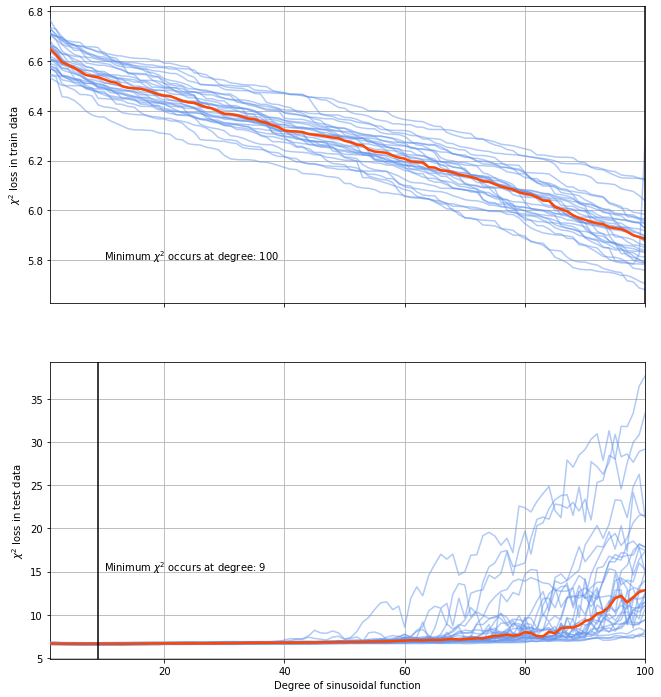

In [7]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16/1.5,18/1.5))

for i in range(30):
    ax[0].plot(degs, np.log(chi2_train[i,:]), color='cornflowerblue', alpha=0.5, zorder=5)
    ax[1].plot(degs, np.log(chi2_test[i,:]), color='cornflowerblue', alpha=0.5, zorder=5)

ax[0].plot(degs, np.log(chi_trn_med), color='orangered', lw=2.5, zorder=10)
ax[1].plot(degs, np.log(chi_tst_med), color='orangered', lw=2.5, zorder=10)

ax[0].axvline(degs[min_chi_trn_arg], color='k', lw=1.5, zorder=10)
ax[1].axvline(degs[min_chi_tst_arg], color='k', lw=1.5, zorder=10)

ax[0].set_xlim([1,100])
ax[1].set_xlim([1,100])

ax[0].text(10, 5.8, r'Minimum $\chi^2$ occurs at degree: ' + str(degs[min_chi_trn_arg]))
ax[1].text(10, 15, r'Minimum $\chi^2$ occurs at degree: ' + str(degs[min_chi_tst_arg]))

ax[1].set_xlabel('Degree of sinusoidal function')
ax[0].set_ylabel(r'$\chi^2$ loss in train data')
ax[1].set_ylabel(r'$\chi^2$ loss in test data')

ax[0].grid()
ax[1].grid()

Let see, how this looks like in the whole dataset...

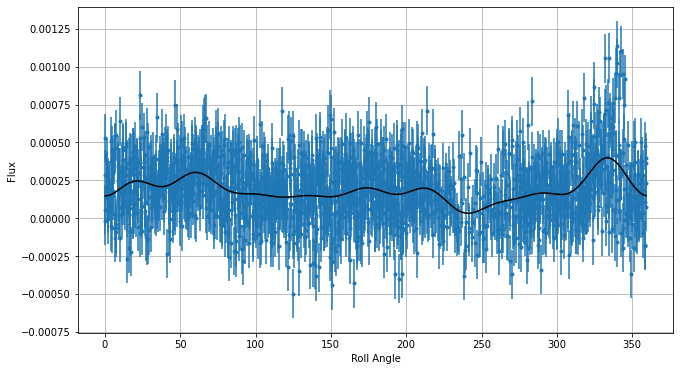

In [8]:
design = utl.des_mat(degs[min_chi_tst_arg], roll)
bets, covs = utl.gls(design, fl, fle)
model_y = design @ bets

plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(roll, fl, yerr=fle, fmt='.', zorder=5)
plt.plot(roll, model_y, 'k', zorder=10)
plt.xlabel('Roll Angle')
plt.ylabel('Flux')
plt.grid()

Depending upon the train and test dataset, degrees of sinusoidal function between 5 and 15 seems to serve the purpose.